In [1]:
%matplotlib inline

In [20]:
from matplotlib import pyplot as plt
import cv2
import numpy as np

## Image Processing

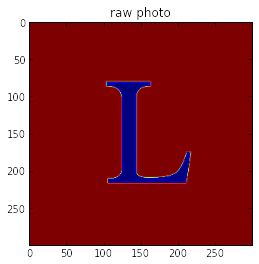

In [21]:
img = cv2.imread('./ell.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(gray)
plt.title('raw photo')
plt.show()

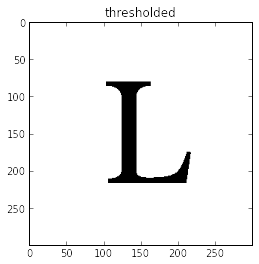

In [23]:
calc_thresh_val, thresh_img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

plt.imshow(thresh_img)
plt.title('thresholded')
plt.show()

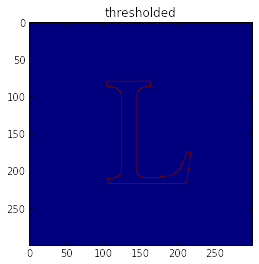

In [24]:
edges = cv2.Canny(img,100,200)

plt.imshow(edges)
plt.title('thresholded')
plt.show()

In [29]:
nonzero_indices = np.argwhere(edges != 0)

nonzero_indices[300]

array([179, 123])

## Gestalt Controls

In [34]:
from pygestalt import nodes
from pygestalt import interfaces
from pygestalt import machines
from pygestalt import functions
from pygestalt.machines import elements
from pygestalt.machines import kinematics
from pygestalt.machines import state
from pygestalt.utilities import notice
from pygestalt.publish import rpc #remote procedure call dispatcher
import time
import io

In [ ]:
class virtualMachine(machines.virtualMachine):
    
    def initInterfaces(self):
        if self.providedInterface: self.fabnet = self.providedInterface #providedInterface is defined in the virtualMachine class.
        else: self.fabnet = interfaces.gestaltInterface('FABNET', interfaces.serialInterface(baudRate = 115200, interfaceType = 'ftdi', portName = '/dev/tty.usbserial-FTZ57QBT'))
    
    def initControllers(self):
        self.xAxisNode = nodes.networkedGestaltNode('X Axis', self.fabnet, filename = '086-005a.py', persistence = self.persistence)
        self.yAxisNode = nodes.networkedGestaltNode('Y Axis', self.fabnet, filename = '086-005a.py', persistence = self.persistence)

        self.xyNode = nodes.compoundNode(self.xAxisNode, self.yAxisNode)

    def initCoordinates(self):
        self.position = state.coordinate(['mm', 'mm'])
    
    def initKinematics(self):
        self.xAxis = elements.elementChain.forward([elements.microstep.forward(4), elements.stepper.forward(1.8), elements.leadscrew.forward(8), elements.invert.forward(True)])
        self.yAxis = elements.elementChain.forward([elements.microstep.forward(4), elements.stepper.forward(1.8), elements.leadscrew.forward(8), elements.invert.forward(False)])		
        self.stageKinematics = kinematics.direct(2) #direct drive on all axes
    
    def initFunctions(self):
        self.move = functions.move(virtualMachine = self, virtualNode = self.xyNode, axes = [self.xAxis, self.yAxis], kinematics = self.stageKinematics, machinePosition = self.position,planner = 'null')
        self.jog = functions.jog(self.move) #an incremental wrapper for the move function
        pass
    
    def initLast(self):
        #self.machineControl.setMotorCurrents(aCurrent = 0.8, bCurrent = 0.8, cCurrent = 0.8)
        #self.xNode.setVelocityRequest(0) #clear velocity on nodes. Eventually this will be put in the motion planner on initialization to match state.
        pass
    
    def publish(self):
        #self.publisher.addNodes(self.machineControl)
        pass
    
    def getPosition(self):
        return {'position':self.position.future()}
    
    def setPosition(self, position  = [None]):
        self.position.future.set(position)

    def setSpindleSpeed(self, speedFraction):
        #self.machineControl.pwmRequest(speedFraction)
        pass

In [37]:
# The persistence file remembers the node you set. It'll generate the first time you run the
# file. If you are hooking up a new node, delete the previous persistence file.
stages = virtualMachine(name="foo", persistenceFile ="test.vmp")

# This is for how fast the (motors move??)
stages.xyNode.setVelocityRequest(8)

TypeError: <module '__main__' (built-in)> is a built-in class

In [ ]:
for move in moves:
    stages.move(move, 0)
    status = stages.xAxisNode.spinStatusRequest()
    # This checks to see if the move is done.
    while status['stepsRemaining'] > 0:
        time.sleep(0.001)
        status = stages.xAxisNode.spinStatusRequest()